In [2]:
import os
import json
import astropy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import Distance
from astropy.cosmology import Planck15

In [3]:
def absmag(m, z):
    '''
    Converts apparent magnitude to absolute magnitude.
    
    Args:
        m (float): apparent magnitude
        z (float): redshift
    '''
    if m is None or m is np.nan or z is None or z is np.nan:
        return np.nan
    else:
        if z==0:
            M = m
        else:
            d = Distance(unit=u.pc, z=float(z), allow_negative=True)
            M = m - 5 * np.log10(d/(10*u.pc)) + 5
        return M
absmag = np.vectorize(absmag)

In [4]:
df_ztfrest = pd.read_csv('ZTFReST.csv')
ztfredshifts = df_ztfrest.dropna(subset=["redshift"]).copy().reset_index(drop=True)

objIds = sorted(list(set(ztfredshifts["id"])))

In [5]:
data_folder = 'data/'
photometry_dict = {}


for root, dirs, files in sorted(os.walk(data_folder)):
    for file in files:
        if file == 'photometry.json':
            folder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:
                photometry_dict[folder_name] = json.load(f)

In [6]:
lc_dict = {key: pd.DataFrame.from_dict(val) for key, val in photometry_dict.items()}

In [7]:
# Initialize an empty dictionary to store non-empty items
flc_dict = {}
elc_dict = {}

# Iterate over the items in lc_dict
for key, value in lc_dict.items():
    # Check if the value is not empty
    if not value.empty:
        # If the value is not empty, add it to the new dictionary
        flc_dict[key] = value
    else:
        # If the value is empty, print the key
        print(f"{key}")
        elc_dict[key] = value

# Now non_empty_lc_dict contains only the items from lc_dict that are not empty

print('number of non-empty lightcurves:', len(flc_dict))
print('number of empty lightcurves:', len(elc_dict))

194.94985-47.75
Swift-J002325.5-141701
Swift-J181727.0-192921
ZTF18abfcmjwm
ZTF18abianhw
ZTF18abukavnm
ZTF18abvkwlam
ZTF19aankdan
ZTF19aapuudk
ZTF19aasexmy
ZTF19abeyvoi
ZTF19abobxik
ZTF19abrpfps
ZTF19abuvqgw
ZTF19acaxbjt
ZTF19acayojs
ZTF19accxzsc
ZTF20aaelulum
ZTF20aazrcbp
ZTF20ababxjv
ZTF20abmocba
ZTF20acigmelm
ZTF22abvvmti
number of non-empty lightcurves: 191
number of empty lightcurves: 23


In [8]:
df_eval = pd.read_csv('candidateEval06-17.csv')
display(df_eval.head())

## print all objects that have an uncertainty in the redshift, then strip the uncertainty from the redshift column
print('objects with uncertainties in redshift:')
for index, row in df_eval.iterrows():
    if '±' in str(row['redshift']):
        print(row['object'])
        df_eval.loc[index, 'redshift'] = float(row['redshift'].split('±')[0])
        
## print number of objects with redshifts
print('number of objects with redshifts:', len(df_eval[df_eval['redshift'].notnull()]))
print('number of objects without redshifts:', len(df_eval[df_eval['redshift'].isnull()]))
print('number of objects with redshifts and classifications:', len(df_eval[df_eval['redshift'].notnull() & df_eval['class'].notnull()]))
print('unique classifications:')
[print(i) for i in df_eval['class'].unique() if pd.notnull(i)];

,object,redshift,class,captures_ztfg_rise,captures_ztfg_fade,captures_ztfr_rise,captures_ztfr_fade,has_ztfi,ztfg_rise,ztfg_fade,ztfr_rise,ztfr_fade,ztfi_rise,ztfi_fade,usability,notes,citation
0,ZTF18aakuewf,0.0636,Ibn,n,y,y,y,n,NaN,58225-58240,58225-58230,58230-58250,NaN,NaN,4,NaN,https://www.aanda.org/articles/aa/abs/2021/05/...
1,ZTF18aalrxas,0.0582 ± 0.0003,IIb,y,y,n,y,n,58227-58230,58229-58235,NaN,58229-58232,NaN,NaN,3,lowish quality ztfr,https://arxiv.org/abs/1903.09262
2,ZTF18abantmh,NaN,NaN,n,n,n,n,n,NaN,NaN,NaN,NaN,NaN,NaN,0,low quality,NaN
3,ZTF18abffyqp,0.031,II,m,m,m,m,n,58307-58309,58308-58315,58307-58309,58308-58315,NaN,NaN,3,data gap at peak; odd second peak,https://arxiv.org/abs/2008.09986
4,ZTF18abvkmgw,0.03847,Ib,y,y,y,y,n,58373-58378,58377-58383,58375-58378,58377-58386,NaN,NaN,3,decent g,https://www.wis-tns.org/object/2018ghd


objects with uncertainties in redshift:
ZTF18aalrxas
ZTF20abummyz
ZTF22acaruqr
number of objects with redshifts: 79
number of objects without redshifts: 111
number of objects with redshifts and classifications: 72
unique classifications:
Ibn
IIb
II
Ib
SN
long GRB
Ia
GRB
Novae
orphan
unclear
afterglow
FOT
FOT;orphan
U Gem
Cataclysmic
Ib/c;Ib-pec
Tidal Disruption Event
Novae;Classical Nova
FBOT
FBOT; Cataclysmic
afterglow; Ic-BL
IIP


In [9]:
hq_cands = df_eval[df_eval['usability'] >= 4]
mq_cands = df_eval[(df_eval['usability'] < 4) & (df_eval['usability'] > 2)]
lq_cands = df_eval[(df_eval['usability'] < 3) & (df_eval['usability'] >= 1)]
z_cands = df_eval.dropna(subset=['redshift'])
hflc_dict = {key: value for key, value in flc_dict.items() if key in hq_cands['object'].values} ## high quality
mflc_dict = {key: value for key, value in flc_dict.items() if key in mq_cands['object'].values} ## medium quality
lflc_dict = {key: value for key, value in flc_dict.items() if key in lq_cands['object'].values} ## low quality
zlc_dict =  {key: value for key, value in flc_dict.items() if key in z_cands['object'].values} ## redshift 

In [10]:
display(zlc_dict['ZTF18aakuewf'].head())
for item in zlc_dict:
    zlc_dict[item]['absmag'] = absmag(zlc_dict[item]['mag'], z_cands[z_cands['object'] == item]['redshift'].values[0])

,obj_id,ra,dec,filter,mjd,snr,instrument_id,instrument_name,ra_unc,dec_unc,origin,id,altdata,created_at,groups,annotations,mag,magerr,magsys,limiting_mag
0,ZTF18aakuewf,NaN,NaN,ztfr,58197.500532,NaN,1,ZTF,None,None,None,201111494,None,2022-04-12T21:52:29.589147,"[{'id': 13, 'created_at': '2020-10-21T06:20:33...",[],NaN,NaN,ab,18.992901
1,ZTF18aakuewf,NaN,NaN,ztfr,58198.394132,NaN,1,ZTF,None,None,None,201112158,None,2022-04-12T21:52:32.025953,"[{'id': 13, 'created_at': '2020-10-21T06:20:33...",[],NaN,NaN,ab,20.430599
2,ZTF18aakuewf,NaN,NaN,ztfr,58198.398623,NaN,1,ZTF,None,None,None,201112159,None,2022-04-12T21:52:32.026048,"[{'id': 13, 'created_at': '2020-10-21T06:20:33...",[],NaN,NaN,ab,20.457500
3,ZTF18aakuewf,NaN,NaN,ztfr,58198.435081,NaN,1,ZTF,None,None,None,201112160,None,2022-04-12T21:52:32.026070,"[{'id': 13, 'created_at': '2020-10-21T06:20:33...",[],NaN,NaN,ab,20.568701
4,ZTF18aakuewf,NaN,NaN,ztfr,58198.455567,NaN,1,ZTF,None,None,None,201112161,None,2022-04-12T21:52:32.026087,"[{'id': 13, 'created_at': '2020-10-21T06:20:33...",[],NaN,NaN,ab,20.582800


/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: div

In [11]:
display(zlc_dict['ZTF18aakuewf'][zlc_dict['ZTF18aakuewf']['absmag'].notnull()])

,obj_id,ra,dec,filter,mjd,snr,instrument_id,instrument_name,ra_unc,dec_unc,...,id,altdata,created_at,groups,annotations,mag,magerr,magsys,limiting_mag,absmag
23,ZTF18aakuewf,243.594398,35.917906,ztfr,58226.340532,34.222286,1,ZTF,None,None,...,201112176,None,2022-04-12T21:52:32.026310,"[{'id': 13, 'created_at': '2020-10-21T06:20:33...",[],18.961000,0.031726,ab,20.611401,-13.389765
24,ZTF18aakuewf,243.594397,35.917906,ztfr,58226.358623,36.912226,1,ZTF,None,None,...,201112177,None,2022-04-12T21:52:32.026324,"[{'id': 13, 'created_at': '2020-10-21T06:20:33...",[],18.871901,0.029414,ab,20.676800,-13.478865
26,ZTF18aakuewf,243.594392,35.917891,ztfr,58226.378947,32.416809,1,ZTF,None,None,...,201112179,None,2022-04-12T21:52:32.026353,"[{'id': 13, 'created_at': '2020-10-21T06:20:33...",[],18.922800,0.033493,ab,20.597799,-13.427966
28,ZTF18aakuewf,243.594377,35.917912,ztfr,58226.414456,34.338093,1,ZTF,None,None,...,201111499,None,2022-04-12T21:52:29.589311,"[{'id': 13, 'created_at': '2020-10-21T06:20:33...",[],18.856501,0.031619,ab,20.611500,-13.494265
30,ZTF18aakuewf,243.594403,35.917928,ztfr,58226.415394,32.527524,1,ZTF,None,None,...,201112181,None,2022-04-12T21:52:32.026381,"[{'id': 13, 'created_at': '2020-10-21T06:20:33...",[],18.849501,0.033379,ab,20.528200,-13.501265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3965,ZTF18aakuewf,243.594426,35.917928,ztfg,60224.139502,5.530807,1,ZTF,None,None,...,546074056,None,2024-03-21T23:15:38.060879,"[{'id': 13, 'created_at': '2020-10-21T06:20:33...",[],19.689800,0.196307,ab,20.078899,-12.660965
3969,ZTF18aakuewf,243.594382,35.917963,ztfg,60231.125058,5.871650,1,ZTF,None,None,...,546074058,None,2024-03-21T23:15:38.060911,"[{'id': 13, 'created_at': '2020-10-21T06:20:33...",[],19.708668,0.184912,ab,20.072325,-12.642098
3972,ZTF18aakuewf,243.594441,35.917938,ztfg,60351.434097,5.709683,1,ZTF,None,None,...,546074059,None,2024-03-21T23:15:38.060926,"[{'id': 13, 'created_at': '2020-10-21T06:20:33...",[],19.691099,0.190157,ab,20.349300,-12.659666
3981,ZTF18aakuewf,243.594399,35.917935,ztfg,60355.514213,5.302430,1,ZTF,None,None,...,546074063,None,2024-03-21T23:15:38.060987,"[{'id': 13, 'created_at': '2020-10-21T06:20:33...",[],19.732599,0.204762,ab,20.308100,-12.618166


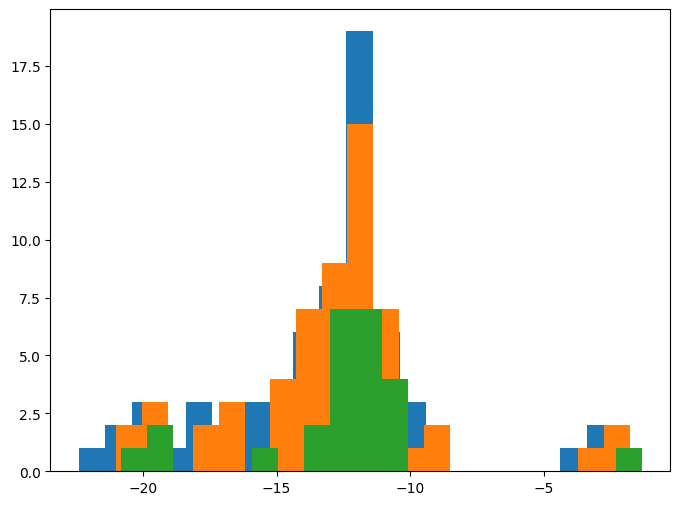

In [12]:
## plot histogram of all peak absolute magnitudes in each band
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
peak_mags = {}
for item in zlc_dict:
    for band in zlc_dict[item]['filter'].unique():
        if band in ['ztfg', 'ztfr', 'ztfi']:
            if band not in peak_mags:
                peak_mags[band] = []
            peak_mags[band].append(zlc_dict[item][zlc_dict[item]['filter'] == band]['absmag'].min())

## drop any inf values
for band in peak_mags:
    peak_mags[band] = [i for i in peak_mags[band] if i != np.inf]

for band in peak_mags:
    ax.hist(peak_mags[band], bins=20,  label=band)

In [13]:
## function to calculate rate of change of magnitude for data points that fall within a certain time window, defined by a min and max time value in the data
def calc_rate(data, min_time, max_time):
    data = data[(data['mjd'] >= min_time) & (data['mjd'] <= max_time)]
    if len(data) > 1:
        rate = (data['mag'].iloc[-1] - data['mag'].iloc[0]) / (data['mjd'].iloc[-1] - data['mjd'].iloc[0])
    else:
        rate = np.nan
    return rate
    

In [14]:
## calculate fade rates for each object in each filter using the timestamps located in df_eval ('ztfg_rise' 'ztfg_fade' and so one for ztfr and ztfi. The structure is 'start-stop' in each cell. If there is not value, there isn't a fade or rise in that filter. The start and stop values do no corrspond to the change in mjd that should be used for calculating the rise and fade, but rather the mjd window that the data points fall within.)
fade_rates = {}
rise_rates = {}
for item, value in zlc_dict.items():
    # print(item)
    #print(value)
    item_fade_rates = {}
    item_rise_rates = {}
    for filter in ['ztfg','ztfr','ztfi']:
        filter_rise_times = df_eval[df_eval['object'] == item][f'{filter}_rise'].values[0]
        filter_fade_times = df_eval[df_eval['object'] == item][f'{filter}_fade'].values[0]
        # print(filter_rise_times, filter_fade_times)
        # print(type(filter_rise_times), type(filter_fade_times))
        if type(filter_rise_times) ==str:
            rise_start, rise_stop = filter_rise_times.split('-')
            item_rise_rates[filter] = calc_rate(value, float(rise_start), float(rise_stop))
        if type(filter_fade_times) == str:
            fade_start, fade_stop = filter_fade_times.split('-')
            item_fade_rates[filter] = calc_rate(value, float(fade_start), float(fade_stop))
            
    fade_rates[item] = item_fade_rates
    rise_rates[item] = item_rise_rates


In [15]:
fade_rates
df_rates = pd.DataFrame(columns=['object', 'filter', 'fade_rate', 'rise_rate'])
for item in fade_rates:
    df_rates = pd.concat([df_rates, pd.DataFrame({'object': item}, index=[0])], ignore_index=True)
    for filter in fade_rates[item]:
        df_rates.loc[df_rates['object'] == item, 'filter'] = filter
        try:
            df_rates.loc[df_rates['object'] == item, 'fade_rate'] = fade_rates[item][filter]
        except:
            df_rates.loc[df_rates['object'] == item, 'fade_rate'] = np.nan
        try:
            df_rates.loc[df_rates['object'] == item, 'rise_rate'] = rise_rates[item][filter]
        except:
            df_rates.loc[df_rates['object'] == item, 'rise_rate'] = np.nan

In [16]:
df_rates
for item in df_rates.iterrows():
    item = item[1]
    item_df = zlc_dict[item['object']]
    item_df = item_df[item_df['filter'] == item['filter']]
    peak_mag = item_df['absmag'].min()
    if peak_mag == np.inf:
        peak_mag = np.nan
    df_rates.loc[(df_rates['object'] == item['object'] ) & (df_rates['filter'] == item['filter']), 'peak_absmag'] = peak_mag
    

In [17]:
display(df_rates)
display(df_rates.describe())

,object,filter,fade_rate,rise_rate,peak_absmag
0,ZTF18aakuewf,ztfr,NaN,NaN,-14.738966
1,ZTF18aalrxas,ztfr,0.297086,NaN,-13.047778
2,ZTF18abffyqp,ztfr,0.142827,-0.252268,-12.488984
3,ZTF18abvkmgw,ztfr,NaN,-0.282926,-12.419196
4,ZTF18abwkrbl,ztfr,0.11317,-0.140666,-12.220878
...,...,...,...,...,...
74,ZTF23abnpdod,ztfi,0.12484,-0.153448,NaN
75,ZTF23abobwsd,ztfi,0.069449,NaN,-12.103182
76,ZTF23absafzo,NaN,NaN,NaN,NaN
77,ZTF23absbqun,ztfr,-0.0059,NaN,-10.076737


,peak_absmag
count,55.000000
mean,-13.313263
std,4.047241
min,-22.412789
25%,-14.790498
50%,-12.419196
75%,-11.728851
max,-1.308570


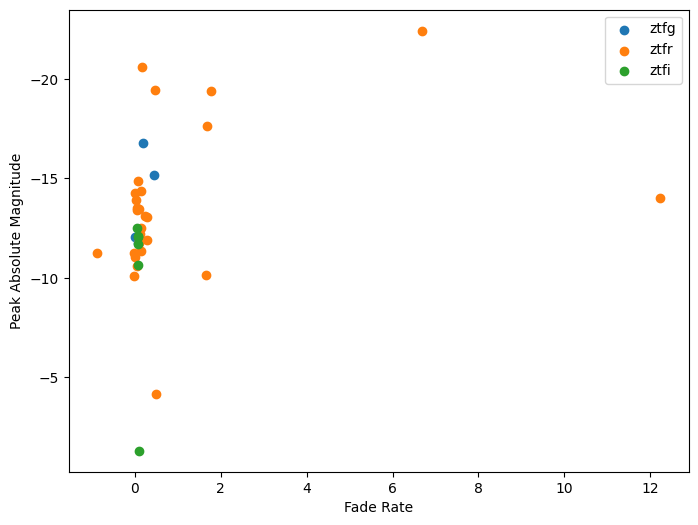

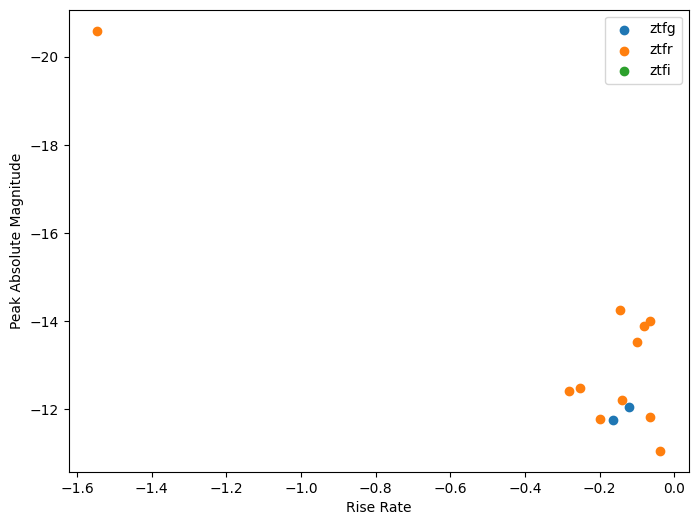

In [18]:
## plot fade rate vs peak absolute magnitude for each object in each filter. color by filter
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for filter in ['ztfg', 'ztfr', 'ztfi']:
    data = df_rates[df_rates['filter'] == filter]
    ax.scatter( data['fade_rate'], data['peak_absmag'], label=filter)
ax.set_ylabel('Peak Absolute Magnitude')
ax.set_xlabel('Fade Rate')
ax.legend()
ax.invert_yaxis()
plt.show();

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for filter in ['ztfg', 'ztfr', 'ztfi']:
    data = df_rates[df_rates['filter'] == filter]
    ax.scatter( data['rise_rate'], data['peak_absmag'], label=filter)
ax.set_ylabel('Peak Absolute Magnitude')
ax.set_xlabel('Rise Rate')
ax.invert_yaxis()
ax.legend();

lcs_bulla_2022/nph1.0e+06_dyn0.001-0.12-0.15_wind0.010-0.03_theta0.00_dMpc0.dat


/tmp/ipykernel_1188218/3453025376.py:127: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fade_values = lightcurve[lightcurve["t"] > max_luminosity_time][filter] if cutoff is None else lightcurve[lightcurve["t"] > max_luminosity_time][lightcurve["t"] < max_luminosity_time + cutoff][filter]
/tmp/ipykernel_1188218/3453025376.py:128: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fade_values_times = lightcurve[lightcurve["t"] > max_luminosity_time]["t"] if cutoff is None else lightcurve[lightcurve["t"] > max_luminosity_time][lightcurve["t"] < max_luminosity_time + cutoff]["t"]


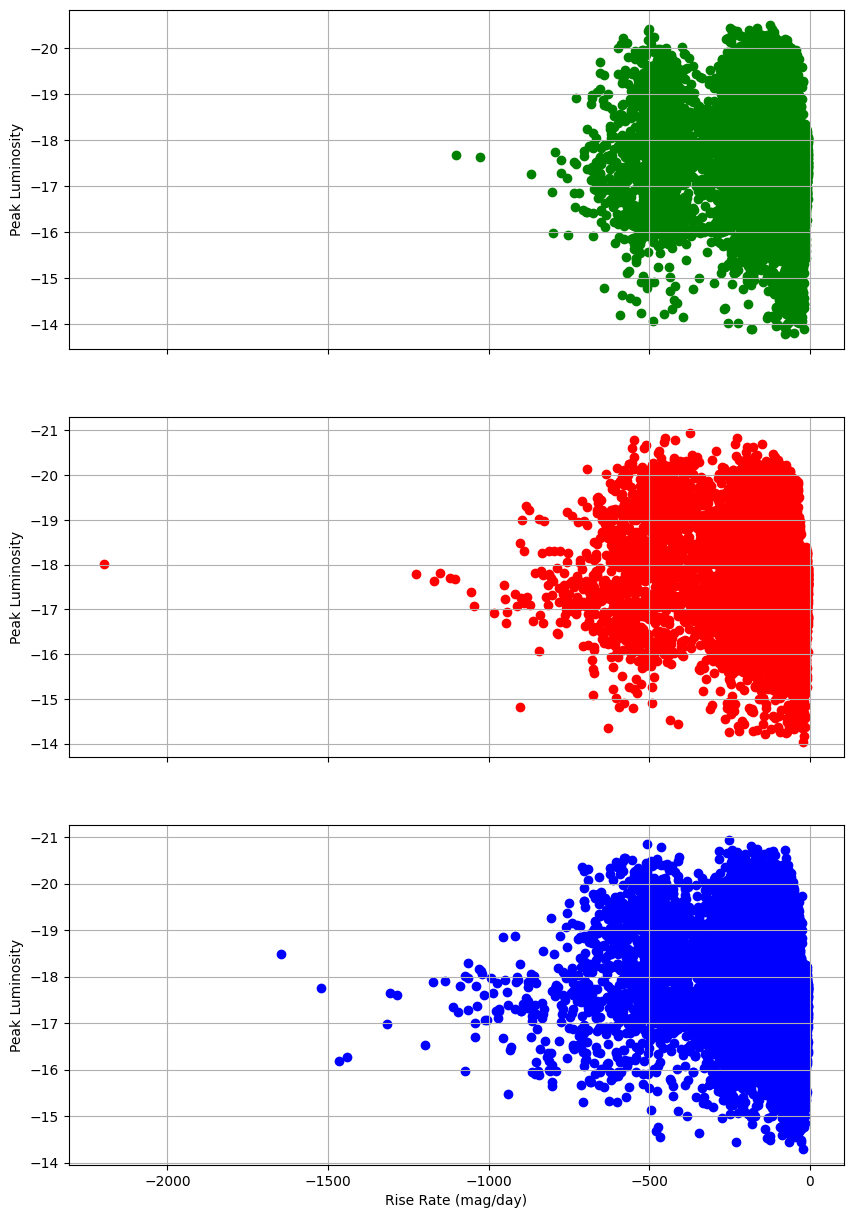

In [1]:
# import json
import numpy as np
import pandas as pd

from sncosmo.bandpasses import _BANDPASSES
from astropy.time import Time
import glob

import matplotlib.pyplot as plt
import seaborn as sns


def loadEvent(filename):
    """
    Reads in lightcurve data from a file and returns data in a dictionary format.
    
    Args:
    - filename (str): Path to lightcurve file
    
    Returns:
    - data (dict): Dictionary containing the lightcurve data from the file. The keys are generally 't' and each of the filters in the file as well as their accompanying error values.
    """
    if filename.endswith(".json"):
        with open(filename) as f:
            data = json.load(f)
            for key in data.keys():
                data[key] = np.array(data[key])
    else:
        lines = [line.rstrip("\n") for line in open(filename)]
        lines = filter(None, lines)

        sncosmo_filts = [val["name"] for val in _BANDPASSES.get_loaders_metadata()]
        sncosmo_maps = {name: name.replace(":", "_") for name in sncosmo_filts}

        data = {}
        for line in lines:
            lineSplit = line.split(" ")
            lineSplit = list(filter(None, lineSplit))
            mjd = Time(lineSplit[0], format="isot").mjd
            filt = lineSplit[1]

            if filt in sncosmo_maps:
                filt = sncosmo_maps[filt]

            mag = float(lineSplit[2])
            dmag = float(lineSplit[3])

            if filt not in data:
                data[filt] = np.empty((0, 3), float)
            data[filt] = np.append(data[filt], np.array([[mjd, mag, dmag]]), axis=0)

    return data

def read_lightcurve_file(filename: str) -> dict:
    """
    Function to read in lightcurve file and create a dictionary containing the time (in days) at which the lightcurves 
    are evaluated and the corresponding values for different filters.
    """

    with open(filename, "r") as f:
        header = list(filter(None, f.readline().rstrip().strip("#").split(" ")))
    df = pd.read_csv(
        filename,
        delimiter=" ",
        comment="#",
        header=None,
        names=header,
        index_col=False,
    )
    df.rename(columns={"t[days]": "t"}, inplace=True)

    return df#.to_dict(orient="series")


bulla_grid_files = sorted(glob.glob("lcs_bulla_2022/*.dat"))
print(bulla_grid_files[0])


bulla_grid_lightcurves = {filename: read_lightcurve_file(filename) for filename in list(bulla_grid_files)}

def get_peak(lightcurve,filter):
    '''
    Function to return the time of peak brightness and the peak brightness value for a given lightcurve and filter.
    
    Args:
    lightcurve (pd.DataFrame): Lightcurve data
    filter (str): Filter for which to find the peak brightness
    '''
    assert filter in lightcurve.columns, f"Filter {filter} not found in lightcurve data."
    
    max_luminosity_time = lightcurve[lightcurve[filter] == lightcurve[filter].min()]["t"].values[0]
    max_luminosity_value = lightcurve[filter].min()
    
    return max_luminosity_time, max_luminosity_value

def calc_rise(lightcurve, filter):
    '''
    Function to calculate the rise time for a given lightcurve and filter.
    
    Args:
    lightcurve (pd.DataFrame): Lightcurve data
    filter (str): Filter for which to calculate the rise time
    '''
    assert filter in lightcurve.columns, f"Filter {filter} not found in lightcurve data."
    
    max_luminosity_time, max_luminosity_value = get_peak(lightcurve, filter)
    rise_values = lightcurve[lightcurve["t"] < max_luminosity_time][filter]
    rise = max_luminosity_value - rise_values.max() ## more robust method would be to do a linear fit to the rise values and calculate the slope
    ## calculate time between first data point and max luminosity time
    rise_time = max_luminosity_time - lightcurve["t"].min()
    rise_rate = rise / rise_time
    
    return rise_rate

def calc_fade(lightcurve, filter, cutoff=5):
    '''
    Function to calculate the fade rate for a given lightcurve and filter.
    
    Args:
    lightcurve (pd.DataFrame): Lightcurve data
    filter (str): Filter for which to calculate the fade rate
    cutoff (int): Number of days after the peak to consider when calculating the fade rate
    '''
    assert filter in lightcurve.columns, f"Filter {filter} not found in lightcurve data."
    
    max_luminosity_time, max_luminosity_value = get_peak(lightcurve, filter)
    fade_values = lightcurve[lightcurve["t"] > max_luminosity_time][filter] if cutoff is None else lightcurve[lightcurve["t"] > max_luminosity_time][lightcurve["t"] < max_luminosity_time + cutoff][filter]
    fade_values_times = lightcurve[lightcurve["t"] > max_luminosity_time]["t"] if cutoff is None else lightcurve[lightcurve["t"] > max_luminosity_time][lightcurve["t"] < max_luminosity_time + cutoff]["t"]
    fade = fade_values.min() - max_luminosity_value
    fade_time = fade_values_times.max() - max_luminosity_time
    fade_rate = fade / fade_time
    
    return fade_rate

fade_cutoff = 2
ztfg_max_luminosity_time, ztfg_max_luminosity_value = [], []
ztfr_max_luminosity_time, ztfr_max_luminosity_value = [], []
ztfi_max_luminosity_time, ztfi_max_luminosity_value = [], []

ztfg_rise_rate, ztfr_rise_rate, ztfi_rise_rate = [], [], []
ztfg_fade_rate, ztfr_fade_rate, ztfi_fade_rate = [], [], []

for key, value in bulla_grid_lightcurves.items():
    ztfg_max_luminosity_time.append(get_peak(value, "ztfg")[0])
    ztfg_max_luminosity_value.append(get_peak(value, "ztfg")[1])
    ztfr_max_luminosity_time.append(get_peak(value, "ztfr")[0])
    ztfr_max_luminosity_value.append(get_peak(value, "ztfr")[1])
    ztfi_max_luminosity_time.append(get_peak(value, "ztfi")[0])
    ztfi_max_luminosity_value.append(get_peak(value, "ztfi")[1])
    
    ztfg_rise_rate.append(calc_rise(value, "ztfg"))
    ztfr_rise_rate.append(calc_rise(value, "ztfr"))
    ztfi_rise_rate.append(calc_rise(value, "ztfi"))
    
    ztfg_fade_rate.append(calc_fade(value, "ztfg", fade_cutoff))
    ztfr_fade_rate.append(calc_fade(value, "ztfr", fade_cutoff))
    ztfi_fade_rate.append(calc_fade(value, "ztfi", fade_cutoff))
    
fig, ax = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
ax[0].grid(), ax[1].grid(), ax[2].grid()
ax[0].scatter(ztfg_rise_rate, ztfg_max_luminosity_value, color='g')
ax[1].scatter(ztfr_rise_rate, ztfr_max_luminosity_value, color='r')
ax[2].scatter(ztfi_rise_rate, ztfi_max_luminosity_value, color='b')


ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis()
ax[0].set_ylabel("Peak Luminosity"), ax[1].set_ylabel("Peak Luminosity"), ax[2].set_ylabel("Peak Luminosity")
ax[2].set_xlabel("Rise Rate (mag/day)");

(None, None, None)

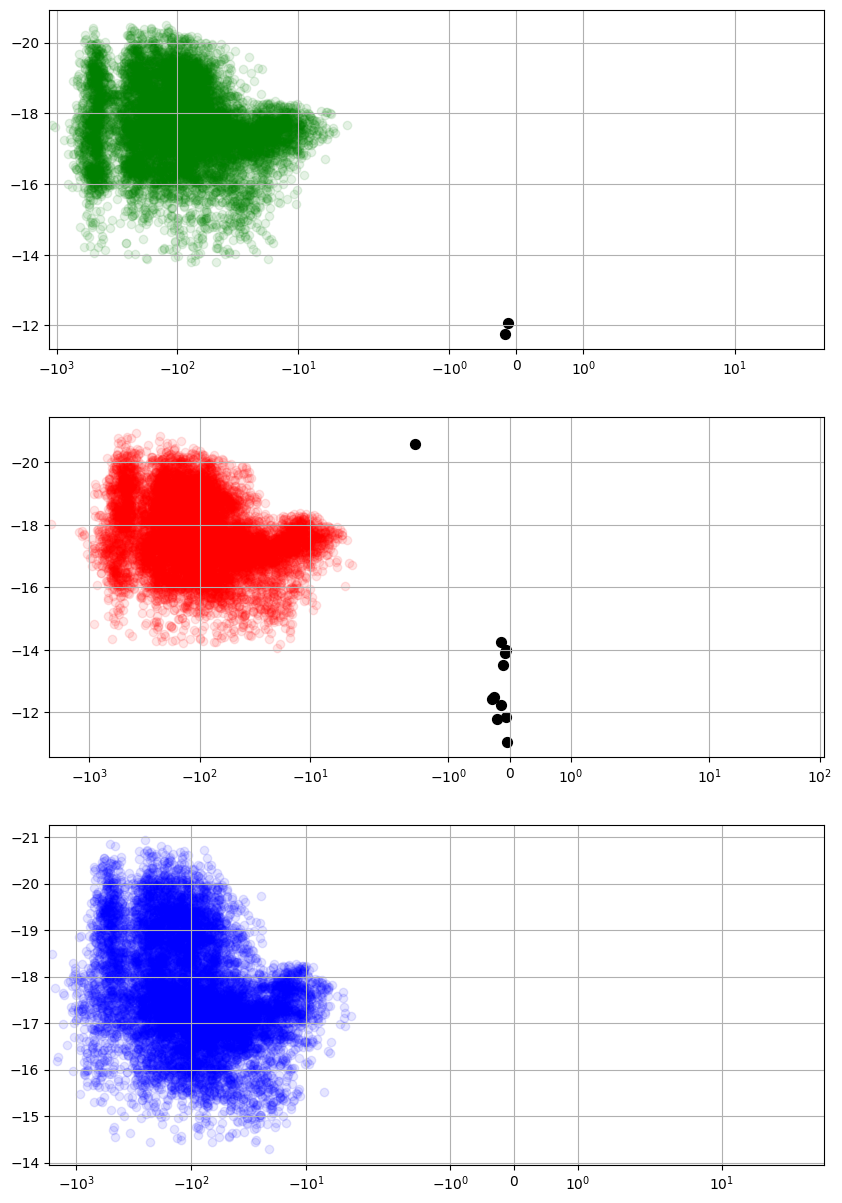

In [28]:
## plot both the rise rates from the bulla grid and the rise rates from the ztf data
fig, ax = plt.subplots(3, 1, figsize=(10, 15), sharex=False)
ax[0].grid(), ax[1].grid(), ax[2].grid()
ax[0].scatter(ztfg_rise_rate, ztfg_max_luminosity_value, color='g', label='Bulla Grid', alpha=0.1)
ax[1].scatter(ztfr_rise_rate, ztfr_max_luminosity_value, color='r', label='Bulla Grid', alpha=0.1)
ax[2].scatter(ztfi_rise_rate, ztfi_max_luminosity_value, color='b', label='Bulla Grid', alpha=0.1)

ax[0].scatter(df_rates[df_rates['filter'] == 'ztfg']['rise_rate'], df_rates[df_rates['filter'] == 'ztfg']['peak_absmag'], color='k', label='ZTF Data', s = 50)
ax[1].scatter(df_rates[df_rates['filter'] == 'ztfr']['rise_rate'], df_rates[df_rates['filter'] == 'ztfr']['peak_absmag'], color='k', label='ZTF Data', s = 50)
ax[2].scatter(df_rates[df_rates['filter'] == 'ztfi']['rise_rate'], df_rates[df_rates['filter'] == 'ztfi']['peak_absmag'], color='k', label='ZTF Data', s = 50)

ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis()
ax[0].set_xscale('symlog'), ax[1].set_xscale('symlog'), ax[2].set_xscale('symlog')

(None, None, None)

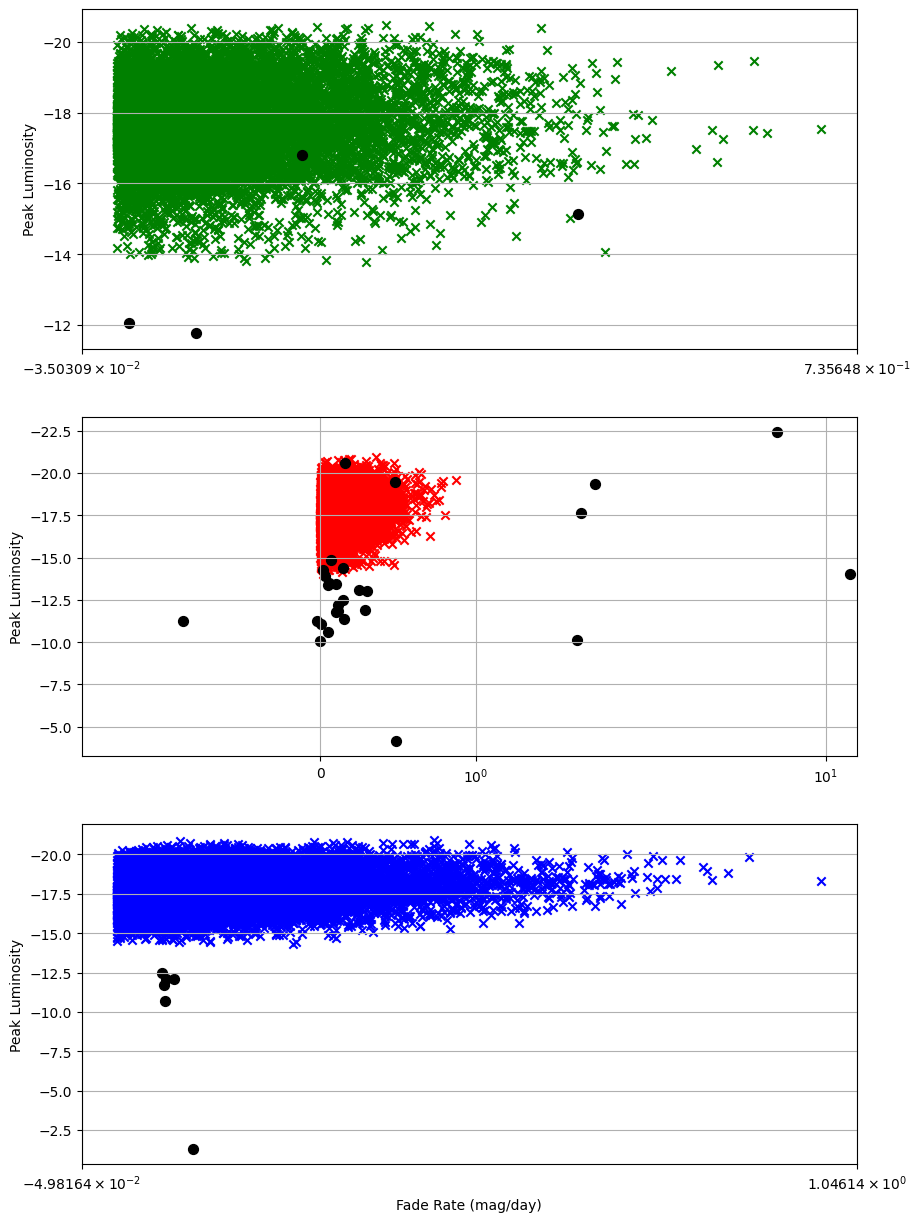

In [29]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15), sharex=False)
ax[0].grid(), ax[1].grid(), ax[2].grid()
ax[0].scatter(ztfg_fade_rate, ztfg_max_luminosity_value, color='g', marker='x')
ax[1].scatter(ztfr_fade_rate, ztfr_max_luminosity_value, color='r', marker='x')
ax[2].scatter(ztfi_fade_rate, ztfi_max_luminosity_value, color='b', marker='x')


ax[0].set_ylabel("Peak Luminosity"), ax[1].set_ylabel("Peak Luminosity"), ax[2].set_ylabel("Peak Luminosity")
ax[2].set_xlabel("Fade Rate (mag/day)");

ax[0].scatter(df_rates[df_rates['filter'] == 'ztfg']['fade_rate'], df_rates[df_rates['filter'] == 'ztfg']['peak_absmag'], color='k', label='ZTF Data', s = 50)
ax[1].scatter(df_rates[df_rates['filter'] == 'ztfr']['fade_rate'], df_rates[df_rates['filter'] == 'ztfr']['peak_absmag'], color='k', label='ZTF Data', s = 50)
ax[2].scatter(df_rates[df_rates['filter'] == 'ztfi']['fade_rate'], df_rates[df_rates['filter'] == 'ztfi']['peak_absmag'], color='k', label='ZTF Data', s = 50)

ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis()
ax[0].set_xscale('symlog'), ax[1].set_xscale('symlog'), ax[2].set_xscale('symlog')

In [15]:
# fig, axs = plt.subplots(10,7, figsize=(20, 20))
# color = {'ztfg': 'g', 'ztfr': 'r', 'ztfi': 'b'}
# fast_fade_count = 0
# for i, (key, value) in enumerate(hflc_dict.items()):
#     ax = axs[i//7, i%7]
#     min_time = value[(value['mag'].notnull())][(value['filter'] == 'ztfg') | (value['filter'] == 'ztfr') | (value['filter'] == 'ztfi')]['mjd'].min()
#     ax.set_xlim(min_time-2, min_time+25)
#     ax.invert_yaxis(), ax.grid()
#     ax.set_title(f'{key}')
#     # ax.set_xlabel('MJD')
#     # ax.set_ylabel('Magnitude')
#     rise_rates = {}
#     fade_rates = {}
#     for filt in ['ztfg', 'ztfr', 'ztfi']:
#         filt_df = value[(value['filter'] == filt)  & (value['mag'].notnull())]
#         if filt_df.empty:
#             continue
#         else:
#             ax.errorbar(filt_df['mjd'], filt_df['mag'], yerr=filt_df['magerr'], fmt='o', label=filt, color=color[filt])
        
#         ## find if it has rise or fade values in the candidateEval05-30.csv file
#         try:
#             rise_time_range = hq_cands[hq_cands['Object'] == key][f'{filt} rise min/max'].values[0]
#             if type(rise_time_range) == str:
#                 rise_time_range = rise_time_range.split('-')
#                 rise_time_range = [float(rise_time_range[0]), float(rise_time_range[1])]
#                 first_data_point = filt_df[filt_df['mjd'] >= rise_time_range[0]].iloc[0]
                
#                 last_data_point = filt_df[filt_df['mjd'] <= rise_time_range[1]].iloc[-1]
#                 rise_rate = (last_data_point['mag'] - first_data_point['mag'])/(last_data_point['mjd'] - first_data_point['mjd'])
#                 rise_rates.update({filt: round(rise_rate,2)})
#                 # print(rise_rate)
#                 # ax.text(0.05, 0.95, f'Rise rate: {rise_rate:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
#         except:
#             print('issue with rise rate for ', key, filt)
#             pass
#         try:
#             fade_time_range = hq_cands[hq_cands['Object'] == key][f'{filt} fade min/max'].values[0]
#             if type(fade_time_range) == str:
#                 fade_time_range = fade_time_range.split('-')
#                 fade_time_range = [float(fade_time_range[0]), float(fade_time_range[1])]
#                 first_data_point = filt_df[filt_df['mjd'] >= fade_time_range[0]].iloc[0]
#                 last_data_point = filt_df[filt_df['mjd'] <= fade_time_range[1]].iloc[-1]
#                 fade_rate = (last_data_point['mag'] - first_data_point['mag'])/(last_data_point['mjd'] - first_data_point['mjd'])
#                 fade_rates.update({filt: round(fade_rate,2)})
#                 # print(fade_rate)
#                 # ax.text(0.05, 0.95, f'Fade rate: {fade_rate:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
#                 # if fade_rate > 0.3:
#                 #     print('{} has a fade rate above 0.3 in {}'.format(key, filt))
#         except:
#             print('issue with fade rate for ', key, filt)
#             pass
#     ## format dictionary to string for plotting
#     if any([float(r) > 0.3 for r in fade_rates.values()]):
#         fast_fade_count += 1
#     rise_rates = ', '.join([f'{k}: {v}' for k,v in rise_rates.items()])
#     fade_rates = ', '.join([f'{k}: {v}' for k,v in fade_rates.items()])
#     ax.text(0.05, 0.20, f'Rise: {rise_rates}', transform=ax.transAxes, fontsize=8, verticalalignment='top') if rise_rates else None
#     ax.text(0.05, 0.10, f'Fade: {fade_rates}', transform=ax.transAxes, fontsize=8, verticalalignment='top') if fade_rates else None
    
# print('number of lightcurves with fade rates above 0.3:', fast_fade_count)       
# fig.tight_layout()
# plt.show()